### 1. Import the Necessary Packages

In [6]:
import gym
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

### 2. Instantiate the Environment and Agent

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = gym.make('CartPole-v0')
env.seed(101)
np.random.seed(101)

print('observation space:', env.observation_space)
print('action space:', env.action_space)
# print('  - low:', env.action_space.low)
# print('  - high:', env.action_space.high)

class Agent(nn.Module):
    def __init__(self, env, h_size=20):
        super(Agent, self).__init__()
        self.env = env
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = 2
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
        
    def set_weights(self, weights):
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        # separate the weights for each layer
        fc1_end = (s_size*h_size)+h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
    
    def get_weights_dim(self):
        return (self.s_size+1)*self.h_size + (self.h_size+1)*self.a_size
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x=F.softmax(x,dim=0)
        
        return x.cpu().data
        
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        prob_value=1
        variance=[]
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action=self.forward(state)
            act=action.numpy()
#             print("action = ",action)
            E=(act[0]*-1 )+(act[1]*1)
            var= act[0]+act[1]-(E**2)
            values,indices=torch.max(action,0)
            prob_value*=values
            action=indices.item()
            variance.append(var)
            
            
            
            state, reward, done, _ = self.env.step(action)
          #  print("timesteps=",t)
            episode_return += reward * math.pow(gamma, t)
          #  print("cum reward right now",episode_return)
            if done:
                break
#       print(variance)
        loss=np.sum(variance)
#         print("loss=",loss)
        return loss
    def evaluate_return(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        prob_value=1
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action=self.forward(state)
            
            values,indices=torch.max(action,0)
            prob_value*=values
            action=indices.item()
            
            
            state, reward, done, _ = self.env.step(action)
            #print("step score",reward)
            #print("timesteps=",t)
            episode_return += reward * math.pow(gamma, t)
           # print("cum reward right now",episode_return)
            if done:
                break
        return (episode_return)
    
agent = Agent(env).to(device)

observation space: Box(4,)
action space: Discrete(2)


In [12]:
agent.s_size

4

In [11]:
def prior_likelihood(sigma_squared, nu_1, nu_2, w, tausq,h,d):
    h = h  # number hidden neurons
    d = d  # number input neurons
#     print(np.shape(w)[0])
    part1 = -1 * ((np.shape(w)[0]) / 2) * np.log(sigma_squared)
    part2 = 1 / (2 * sigma_squared) * (sum(np.square(w)))
    log_loss = part1 - part2 - (1 + nu_1) * np.log(tausq) - (nu_2 / tausq)
    return log_loss

def likelihood_func(sigma,gamma, max_t,w, tausq,n_iterations,loss):
        #y = data[:, self.topology[0]]
        
        rmse = np.mean(loss)
        loss = -0.5 * np.log(2 * math.pi * tausq) - 0.5 * np.square(loss) / tausq
        return [np.sum(loss), rmse]

Episode 10	Average Score: 45.70
Episode 20	Average Score: 46.25
Episode 30	Average Score: 48.43
Episode 40	Average Score: 50.67
Episode 50	Average Score: 54.08
Episode 60	Average Score: 54.80
Episode 70	Average Score: 54.07
Episode 80	Average Score: 55.94
Episode 90	Average Score: 56.33
Episode 100	Average Score: 57.31
Episode 110	Average Score: 58.91
Episode 120	Average Score: 60.97
Episode 130	Average Score: 61.14
Episode 140	Average Score: 63.09
Episode 150	Average Score: 64.07
Episode 160	Average Score: 68.45
Episode 170	Average Score: 72.16
Episode 180	Average Score: 74.42
Episode 190	Average Score: 77.65
Episode 200	Average Score: 80.51
Episode 210	Average Score: 83.81
Episode 220	Average Score: 86.25
Episode 230	Average Score: 89.25

Environment solved in 132 iterations!	Average Score: 90.42


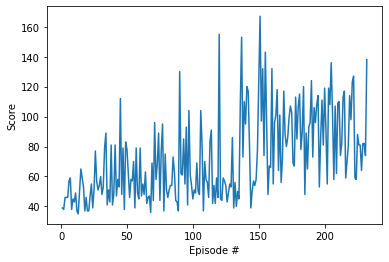

In [25]:
from sklearn.preprocessing import normalize

def cem(n_iterations=10, max_t=200, gamma=1, print_every=10, pop_size=50, elite_frac=0.3, sigma=0.5):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    n_elite=int(pop_size*elite_frac)
    agent = Agent(env).to(device)

    scores_deque = deque(maxlen=100)
    scores = []
#     best_weight = sigma*np.random.randn(agent.get_weights_dim())
    #print("rrrrrrrrr",agent.get_weights_dim())
    
    
    #MCMC variables
    pos_w = np.ones((n_iterations, agent.get_weights_dim()))
    pos_tau = np.ones((n_iterations, 1))

    rmse_train = np.zeros(n_iterations)
    rmse_test = np.zeros(n_iterations)



    w = sigma*np.random.randn(agent.get_weights_dim())
    w_proposal = np.random.randn(agent.get_weights_dim())


    step_w = 0.02  # defines how much variation you need in changes to w
    step_eta = 0.01


    #now declare the nn and do aforward pass
    weights_pop = [w + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(n_iterations)]
    loss= np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])
#     print("before normalization = ",rewards)
#     print("rewards ",normalize(rewards[:,np.newaxis], axis=0).ravel())
    
    tau_pro = np.var(loss)
    if tau_pro==0:
        eta=0.000001
    else:
        eta = np.log(np.var(loss))
    
    
#     print("tau is",tau_pro)
#     print("eta is",eta)
    sigma_squared = 25
    nu_1 = 0
    nu_2 = 0
    prior_likelihoo = prior_likelihood(sigma_squared, nu_1, nu_2, w, tau_pro,agent.h_size,agent.s_size)  # takes care of the gradients
#     print("prior likelihood=",prior_likelihoo)
    [likelihood, rmsetrain] = likelihood_func( sigma,gamma,max_t,w, tau_pro,n_iterations,loss)

#     print("likelihood=",likelihood)
    naccept = 0
    

    for i_iteration in range(1, n_iterations+1):
#         print("iter= ",i_iteration)
        #weights_pop = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        #print("this is the real one time evalute output:",agent.evaluate(best_weight, gamma, max_t))
        #print("reward is",rewards)
        
        
        
        w_proposal = w + np.random.normal(0, step_w,agent.get_weights_dim())
        eta_pro = eta + np.random.normal(0, step_eta, 1)
        tau_pro = math.exp(eta_pro)
        
        loss = (agent.evaluate(w_proposal, gamma, max_t))
#         print(reward/i_iteration)
#         norm_rew_pro = reward/200.0
#         print("reward=",reward)
        [likelihood_proposal, rmsetrain] = likelihood_func(sigma,gamma,max_t,w_proposal, tau_pro,n_iterations,loss)
      
      #  print("likelihood proposal=",likelihood_proposal)
        prior_prop = prior_likelihood(sigma_squared, nu_1, nu_2, w_proposal, tau_pro,agent.h_size,agent.s_size)
        diff_likelihood = likelihood_proposal - likelihood/n_iterations
        
        diff_priorliklihood = prior_prop - prior_likelihoo
        print(diff_priorliklihood,diff_likelihood)
#         print(diff_likelihood+diff_priorliklihood)
        
#         print("sum= ",diff_likelihood)
        
        
        
        mh_prob = min(0, (diff_likelihood+diff_priorliklihood))
#         print("metropolis hastings probablitiy = ",mh_prob)
        
        u = random.uniform(0, 1)
        if u < mh_prob:
            # Update position
            #print(i, ' is the accepted sample')
            naccept += 1
            
            w = w_proposal
            eta = eta_pro
                    
            # print i, 'rejected and retained'

        rewards = agent.evaluate_return(w, gamma=1.0)
        scores_deque.append(rewards)
        scores.append(rewards)       
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores

        
#         elite_idxs = rewards.argsort()[-n_elite:]
#         elite_weights = [weights_pop[i] for i in elite_idxs]
#         best_weight = np.array(elite_weights).mean(axis=0)

#         reward = agent.evaluate(best_weight, gamma=1.0)
#         scores_deque.append(reward)
#         scores.append(reward)
        
#         torch.save(agent.state_dict(), 'checkpoint.pth')
        
#         if i_iteration % print_every == 0:
#             print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

#         if np.mean(scores_deque)>=90.0:
#             print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
#             break
#     return scores

scores = cem()

# # plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
# load the weights from file
agent.load_state_dict(torch.load('checkpoint.pth'))

state = env.reset()
while True:
    state = torch.from_numpy(state).float().to(device)
    with torch.no_grad():
        action = agent(state)
        
    env.render()
    action = (round(((max(action))).item()))
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()